# Self-Driving Car Engineer Nanodegree

## Deep Learning Project: Build a Traffic Sign Recognition Classifier


# Notebook and project writeup

*This Notebook has been altered to include the project writeup and Code in one file.*

The whole solution is based on the example LeNet implementation from https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb as presented in Lesson 9

---
## Step 0: Load The Data

First, the training, test and validation data is loaded from the provided German traffic sign database.

In case there is no test data it is created. (I found an older dataset not including test data first :/)

In [23]:
# Load pickled data
import pickle
from sklearn.model_selection import train_test_split
from pathlib import Path
import platform
print(platform.python_version())


import csv

names = {}
with open('signnames.csv',newline='') as signnames:
    reader = csv.reader(signnames)
    next(reader)
    names = dict(reader)
    
#print(names)    

training_file = './datasets/train.p'
validation_file= './datasets/valid.p'
testing_file = './datasets/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']    
    
val_file = Path(validation_file)
if val_file.is_file():       #already split
    print('found test data')
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)
    X_valid, y_valid = valid['features'], valid['labels']    
else:                        #get some validation data
    print('split test data')
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    train['features']=X_train
    train['labels']=y_train    
    valid=test
    valid['features']=X_valid
    valid['labels']=y_valid
    with open(training_file, 'wb') as f:
        pickle.dump(train, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(validation_file, 'wb') as f:
        pickle.dump(valid, f, protocol=pickle.HIGHEST_PROTOCOL)
        
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))        

3.5.2
found test data


---

## Step 1: Dataset Summary & Exploration

To verify the data and get a first idea of it's representation, data set sizes and image dimensions are printed out

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

For further understanding of the actual input data used, 25 indizies are selected randomly and printed with their associated class ID and it's name.

Furthermore a histogram shows how many images there are for each class.

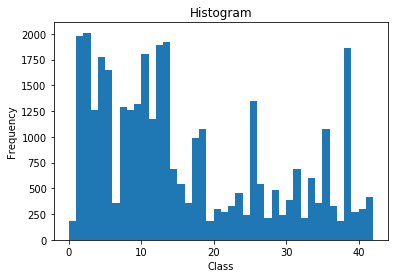

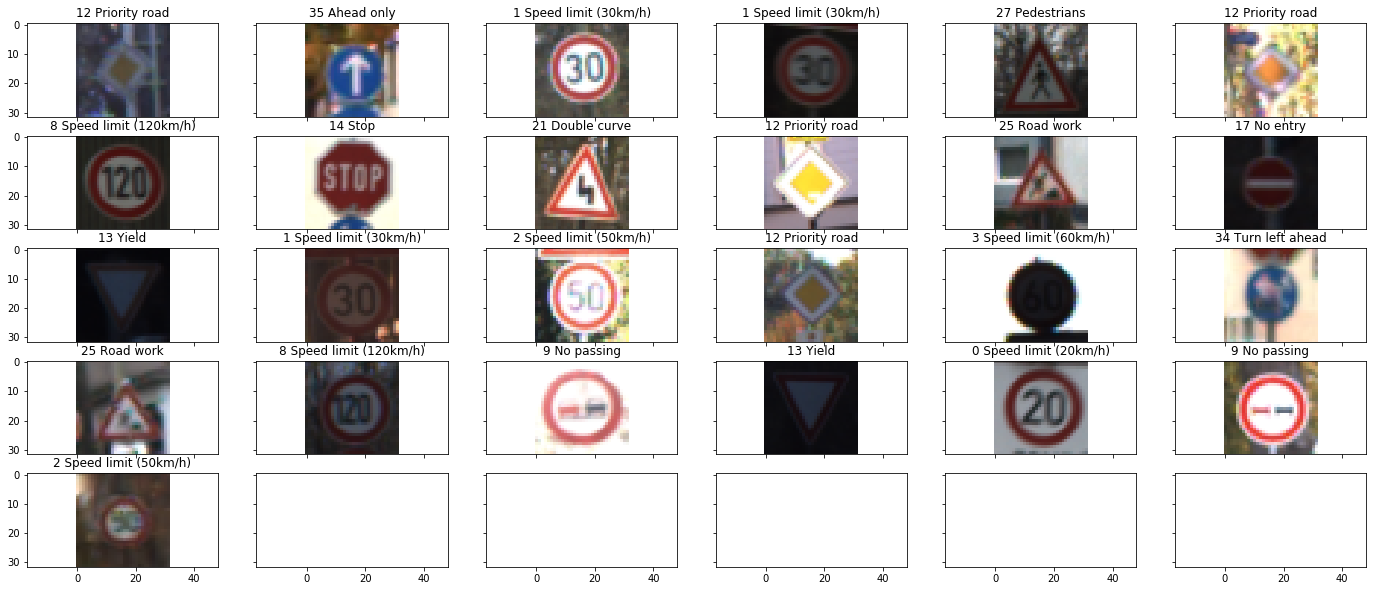

In [26]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import math
%matplotlib inline  

n_images = 25 # we may have an empty second row, but i'm to lazy to fix that

i_cols = 6 #math.ceil(math.sqrt(n_images))
i_rows = max(math.ceil(n_images/i_cols),2)

plt.hist(y_train,bins=np.unique(y_test))
plt.title("Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

f, plots = plt.subplots(i_rows,i_cols, sharex='col', sharey='row', figsize=(4*i_cols, 2*i_rows))


n=0
while n < n_images:    
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()    
    i=(n % i_cols)
    j=(n // i_cols)    
    plots[j,i].imshow(image)
    plots[j,i].set_title(str(y_train[index])+' '+names[str(y_train[index])])
    n+=1
    


----

## Step 2: Design and Test a Model Architecture

This section describes (and implements):
* The preprocessing pipeline for the images
* The decomposition of the given LeNet neuronal network into distinct 'layer-functions' for simpler reuse
* The recreation of the LeNet with these functions, and later adaption
* NN Training Pipeline
* NN Evaluation Pipeline
* NN Training

### Pre-process the Data Set

For preprocessing of the images, first a few helper functions have been copied from the lane detection project.

In [4]:
### (some) helper functions from the lane detection
import cv2

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

### Images
To prevent errors and make sure all processing is the same, a central preprocessing function has been declared that can be called in each pipeline later where needed instead of going through all data at once.

As can be seen in the leftovers in the code (after the 1st return in `processSingleImage`) I first experimented with an additional gray-scale layer and a preprocessed canny detection as additional input data to the NN. Each image then would have had a dimension of 32x32x5.

Furthermore the proprocessing ensures that images have at least 3 dimensions. Converting images only to grayscale prior resulted in problems data was now 32x32 (2 dimensional) instead of 32x32x1.

In the end, I figured a simple normalization on each layer got good results. This also leaves all information for the NN (still 3 'colors') and does no processing the NN could do 'on it's own' (e.g. find edges, ignore color information).

### Data
Additionaly the order of the training data has been randomized to destroy possible patterns

In [5]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)


def normalize_layers(data_in,low=0,high=255):
    ### return values between -1 and 1
    ones = np.ones_like(data_in)    
    delta=(high-low)/2
    data_out = np.minimum(ones,(data_in/delta) - 1.0)
    ones = ones * -1
    return np.maximum(ones,data_out)
            
# preparing image modifications on all data
# train, validation, test, should be something done on input
def processSingleImage(image_in):
    
    canny_low = 50
    canny_high = 150   
    
    return normalize_layers(image_in) #nothing else anymore
    
    im_gray=grayscale(image_in)
    im_edges=canny(im_gray,canny_low,canny_high)        
    
    result = np.empty((image_in.shape[0],image_in.shape[1],5))
    
    result[:,:,0] = image_in[:,:,0]
    result[:,:,1] = image_in[:,:,1]
    result[:,:,2] = image_in[:,:,2]
    result[:,:,3] = im_edges
    result[:,:,4] = im_gray        
        
    if result.ndim < 3:
        result = np.expand_dims(result, axis=2)
                
        
    return normalize_layers(result)

def imagePreprocessing(images_in):
    #print(type(images_in))
    out = []
    for i in range(len(images_in)):
        # how to make a numpy nd  not a list when only one color channel is there, needs to be 32,32,1 not 32,32
        out.append(processSingleImage(images_in[i]))
    return out



### simpler layer functions

For easier recombination of layers and to not manually deal with filter sizes, I defined functions for each processing layer/type in the original LeNet.

These functions take the desired output size or divisor as parameter and calculate the shapes for truncation and pooling on their own

In [6]:
import tensorflow as tf

from tensorflow.contrib.layers import flatten

def conv(data,out_size_xy_z,mu,sigma,stenzil_z=None):
    if stenzil_z == None:        
        try:
            stenzil_z = data.get_shape()[3]
        except:
            print('e')
            stenzil_z = 1
        
    xy = data.get_shape()[1] - out_size_xy_z[0]+1
    z=out_size_xy_z[1]
    
    sh=(int(xy),int(xy),int(stenzil_z),int(z))
    
    c_W = tf.Variable(tf.truncated_normal(shape=sh, mean = mu, stddev = sigma))
    c_b = tf.Variable(tf.zeros(z))
    c   = tf.nn.conv2d(data, c_W, strides=[1, 1, 1, 1], padding='VALID') + c_b    
    return tf.nn.relu(c)

def pool_max(data,divisor=2):
    return tf.nn.max_pool(data, ksize=[1, divisor, divisor, 1], strides=[1, divisor, divisor, 1], padding='VALID')

def drop(data,keep):    
    return tf.nn.dropout(data,keep)


def full(flat_data,number_out,mu,sigma,activate=True):
            
    number_in=int(flat_data.get_shape()[1])

    fc_W = tf.Variable(tf.truncated_normal(shape=(number_in, number_out), mean = mu, stddev = sigma))
    fc_b = tf.Variable(tf.zeros(number_out))
    
    fc =  tf.matmul(flat_data, fc_W) + fc_b    
    if activate:
        return tf.nn.relu(fc)
    else:
        return fc
    




## Net definition

The LeNet has been rebuild with these layer functions first and then adopted to the needs in this project:

In [7]:
# placeholders for dropout (as we don't want the dropout in evaluation and inference)
keep1 = tf.placeholder(tf.float32)
keep2 = tf.placeholder(tf.float32)
keep3 = tf.placeholder(tf.float32)
    
def LeNet_my(x,out_number):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    #drop_1 = 0
    #drop_2 = 0.3
    #drop_3 = 0.2    
    
    # in 32x32x3    
    c1 = pool_max(conv(x,[28,6],mu,sigma))
    
    #14x14x6        
    
    c2 = pool_max(conv(c1,[10,16],mu,sigma))
    
    #5x5x16
        
    c2=drop(c2,keep1)
    
    fl = flatten(c2) # 400
    
    fc1 = full(fl,120,mu,sigma) #120
    
    fc1=drop(fc1,keep2)
    
    fc2 = full(fc1,84,mu,sigma) #84
    
    fc2=drop(fc2,keep3)
    
    logits = full(fc2,out_number,mu,sigma,False) #43
    
    return logits

### Final Network

As can be seen in the Code above, the finaly Network consitsts of the following Layers:

| Layer         		| Resulting Size |   Description	        					| 
|:---------------------:|:-----------:|:--------------------------------:| 
|Input| 32x32x3 | Normalized [-1 .. 1] |
|Convulution| 28x28x6 | 3x3 ,Valid Padding |
|Max Pooling | 14x14x6 | 2x2, Valid Padding | 
|Convulution| 10x10x16 | 3x3 ,Valid Padding |
|Max Pooling | 5x5x16 | 2x2, Valid Padding | 
| DropOut | " | Keep 100 % |
| Flatten | 400 | |
| Fully connected | 120 | |
| DropOut | " | Keep 65 % |
| Fully connected | 84 | |
| DropOut | " | Keep 65 % |
| Fully connected | 43 | |

Dropouts are only active in training

## Train, Validate and Test the Model

## Training Pipeline

The training pipeline is essentially identical to the one in https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb

Sizes are now variable according to input to the net after preprocessing.

In [8]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

#preprocess one images to find input sizes
dummy = imagePreprocessing(X_train) # preprocess images

sx = dummy[0].shape[0]
sy = dummy[0].shape[1]
sz = dummy[0].shape[2]


print('Shape after prepocessing:')
print((sx, sy, sz))

#sx = image_shape[0]
#sy = image_shape[1]
#sz = image_shape[2]

if sz < 2:
    x = tf.placeholder(tf.float32, (None, sx, sy,1))
else:
    x = tf.placeholder(tf.float32, (None, sx, sy, sz))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

## PARAMS
RATE = 0.001
EPOCHS = 30
BATCH_SIZE = 128
Drop1 = 0.0 # 0
Drop2 = 0.35 # 3
Drop3 = 0.35 # 3

logits = LeNet_my(x,n_classes)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = RATE)
training_operation = optimizer.minimize(loss_operation)


Shape after prepocessing:
(32, 32, 3)


## Model Evaluation

Unchanged from https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb except for the variables for the dropout and the call to image preprocessing

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        
        batch_x = imagePreprocessing(batch_x) # preprocess images
        
        ## no dropout when evaluating
        
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep1: 1.0, keep2: 1.0, keep3: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model¶

Unchanged from https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb except for the variables for the dropout and the call to image preprocessing

I have used a batch size of 128 in 30 epochs at a learning rate of 0.001

In [11]:


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
            batch_x = imagePreprocessing(batch_x) # preprocess images
            
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep1: 1.0-Drop1, keep2: 1.0-Drop2, keep3: 1.0-Drop3})            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.702

EPOCH 2 ...
Validation Accuracy = 0.834

EPOCH 3 ...
Validation Accuracy = 0.890

EPOCH 4 ...
Validation Accuracy = 0.901

EPOCH 5 ...
Validation Accuracy = 0.914

EPOCH 6 ...
Validation Accuracy = 0.933

EPOCH 7 ...
Validation Accuracy = 0.929

EPOCH 8 ...
Validation Accuracy = 0.938

EPOCH 9 ...
Validation Accuracy = 0.946

EPOCH 10 ...
Validation Accuracy = 0.946

EPOCH 11 ...
Validation Accuracy = 0.941

EPOCH 12 ...
Validation Accuracy = 0.938

EPOCH 13 ...
Validation Accuracy = 0.947

EPOCH 14 ...
Validation Accuracy = 0.958

EPOCH 15 ...
Validation Accuracy = 0.955

EPOCH 16 ...
Validation Accuracy = 0.951

EPOCH 17 ...
Validation Accuracy = 0.961

EPOCH 18 ...
Validation Accuracy = 0.951

EPOCH 19 ...
Validation Accuracy = 0.959

EPOCH 20 ...
Validation Accuracy = 0.959

EPOCH 21 ...
Validation Accuracy = 0.960

EPOCH 22 ...
Validation Accuracy = 0.956

EPOCH 23 ...
Validation Accuracy = 0.966

EPOCH 24 ...
Validation Accura

### TEST on before untouched Testdata

After building the layers in the NN and tweaking the image preprocessing and the parameters (especially the dropouts) to an acceptable result on the validation data, the NN was tested against before untouched data

In [12]:
with tf.Session() as sess:    
    loaded = tf.train.import_meta_graph('./lenet.meta')
    loaded.restore(sess, "./lenet")
    
    acc_training = evaluate(X_train, y_train)
    acc_validation = evaluate(X_valid, y_valid)
    acc_test = evaluate(X_test, y_test)
        
    print("Accuracies Train:{:.3f}, Validate:{:.3f}, TEST:{:.3f}".format(acc_training, acc_validation, acc_test))    

Accuracies Train:0.998, Validate:0.963, TEST:0.942


---

## Step 3: Test a Model on New Images

To get an impression on the performance of the net on other data, 5 images of german traffix signs have been downloaded to be tested against the created NN.

The images have been sized to 32x32 pixel externaly.

Image 1 is of a type not available in the 43 classes in the test data, but I thought I might give it a try anyway to see what happens.

### Load and Output the Images

IS DATA


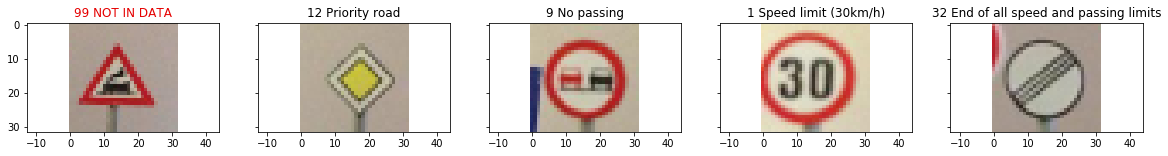

In [11]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from skimage import io
my_images = []
my_labels = [99,12,9,1,32] # first sign class is not in training data, set to '99'  ;)
my_files = ('01','02','03','04','05')
ext = '.png'

for f in my_files:
    img = io.imread('img/'+f+ext) # already 32x32 px
    my_images.append(img[:,:,:3])
    

    
im_fig, im_plots = plt.subplots(1,5, sharex='col', sharey='row', figsize=(4*5, 2*1))

n_images = 5

n=0
print('IS DATA')
while n < n_images:        
    image = my_images[n].squeeze()    
    im_plots[n].imshow(image)
    try:
        im_plots[n].set_title(str(my_labels[n])+' '+names[str(my_labels[n])])
    except:
        im_plots[n].set_title(str(my_labels[n])+' NOT IN DATA', color='xkcd:red')
    n+=1    



### Predict the Sign Type for Each Image

To predict the signs with the NN, the images first are preprocessed as all the training data.

PREDICTION


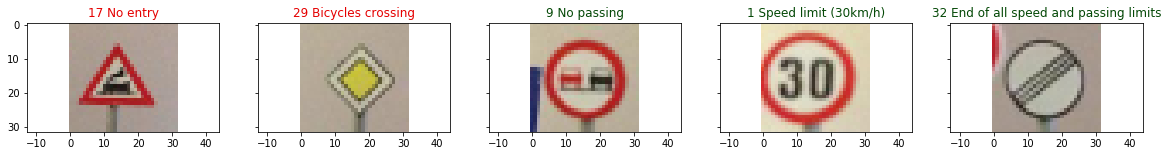

In [28]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

softmax = tf.nn.softmax(logits)
topk = tf.nn.top_k(softmax, k=5)

k_values = 0;

my_processed = imagePreprocessing(my_images) #preprocessing


predicted_labels = []

with tf.Session() as sess:
    loaded2 = tf.train.import_meta_graph('./lenet.meta')
    loaded2.restore(sess, "./lenet")
    
    #sm = sess.run(softmax, feed_dict={x: my_processed, keep1: 1.0, keep2: 1.0, keep3: 1.0})
    k_values = sess.run(topk, feed_dict={x: my_processed, keep1: 1.0, keep2: 1.0, keep3: 1.0})
    k= k_values;
    #print(sm)
    
    #print(k.values[:]);
    predicted_labels=k.indices[:,0]
    #print(k.indices[:,0:3])
    #for ki in k.indices[:,0]:
    #    print(names[str(ki)])
    

    
    im_fig2, im_plots2 = plt.subplots(1,5, sharex='col', sharey='row', figsize=(4*5, 2*1))

    n_images = 5

    n=0
    print('PREDICTION')
    while n < n_images:        
        image = my_images[n].squeeze()    
        im_plots2[n].imshow(image)
        li = predicted_labels[n]
        
        if (li == my_labels[n]):  # did you know there is 'xkcd'-surveyed colors available? :D
            clr='xkcd:darkgreen'
        else:
            clr='xkcd:red'
            
        try:
            im_plots2[n].set_title(str(li)+' '+names[str(li)],color=clr)
        except:
            im_plots2[n].set_title(str(li)+' NOT IN DATA')
        n+=1    
    

### Analyze Performance

3 of the 5 images where classified correctly. Image 1 was not in the dataset and image 2 was wrong classified.

It is stunning that especially the 'priority road' is misclassified totally (not even among the 5 most propable, see softmax) as it would seem so very unique. It is square (unlike most others), it has yellow (unlike most others) and the class (12) isn't even especially underrepresented in the training data. 

In [13]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

count_total = len(my_labels)
count_correct = 0
for i in range(count_total):
    if my_labels[i]==predicted_labels[i]:
        count_correct += 1
        
print("PERFORMANCE ON OWN IMAGES: {:.0f}%".format(count_correct*100/count_total))

PERFORMANCE ON OWN IMAGES: 60%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [21]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

print("SOFTMAX Values:")

for i in range(count_total):
    print('For image: '+str(i+1))
    out = ''
    for j in range(5):
        out = out + "{:.0f}% (ID: {});  ".format(k_values.values[i,j]*100,k_values.indices[i,j])
    print(out)

SOFTMAX Values:
For image: 1
64% (ID: 17);  27% (ID: 14);  6% (ID: 30);  1% (ID: 25);  1% (ID: 29);  
For image: 2
47% (ID: 29);  37% (ID: 31);  7% (ID: 13);  6% (ID: 25);  1% (ID: 19);  
For image: 3
100% (ID: 9);  0% (ID: 10);  0% (ID: 13);  0% (ID: 3);  0% (ID: 0);  
For image: 4
33% (ID: 1);  32% (ID: 39);  19% (ID: 8);  12% (ID: 2);  3% (ID: 37);  
For image: 5
100% (ID: 32);  0% (ID: 41);  0% (ID: 6);  0% (ID: 12);  0% (ID: 36);  


## Unfortunately no optional part this time